   age          workclass  fnlwgt   education  education-num  \
0   50   Self-emp-not-inc   83311   Bachelors             13   
1   38            Private  215646     HS-grad              9   
2   53            Private  234721        11th              7   
3   28            Private  338409   Bachelors             13   
4   37            Private  284582     Masters             14   

        marital_status          occupation    relationship    race      sex  \
0   Married-civ-spouse     Exec-managerial         Husband   White     Male   
1             Divorced   Handlers-cleaners   Not-in-family   White     Male   
2   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
3   Married-civ-spouse      Prof-specialty            Wife   Black   Female   
4   Married-civ-spouse     Exec-managerial            Wife   White   Female   

   capital_gain  capital_loss  hour_per_week  native_country  income  
0             0             0             13   United-States   <=50K 

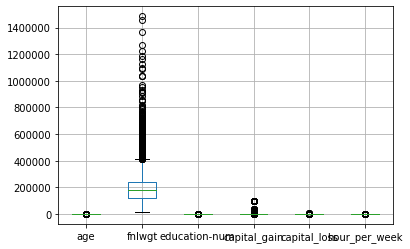

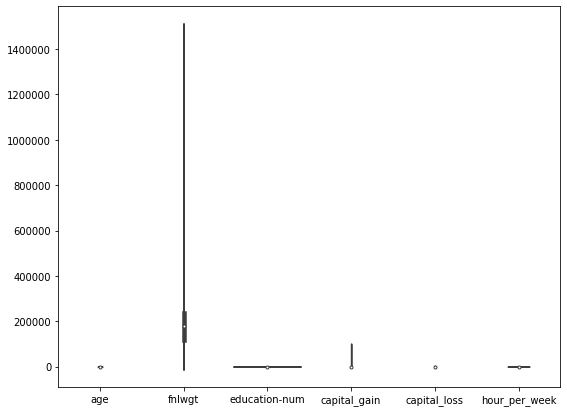

In [ ]:
import script

df = script.read_dataset()
script.handle_nulls(df)
script.handle_outliers(df)
script.discretization(df)
script.correlation(df)
